In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import robust_loss_pytorch.general


# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 100
scale_true = 0.7
shift_true = 0.15
scale2_true = 2
p = 0.5 # rate to be a member of one group
U = np.random.binomial(1, p, n)

x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y[U==1] = scale2_true * x[U==1]**2 + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)
U = torch.Tensor(U)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

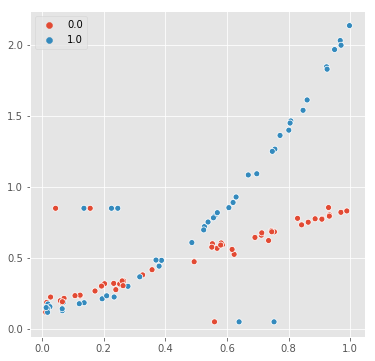

In [2]:
plt.figure(0, figsize=(6,6))
sns.scatterplot(x, y, hue=U)

## Linear regression with regular MSE

0   : loss=14.871566
100 : loss=6.779482
200 : loss=5.595796
300 : loss=5.512252
400 : loss=5.510237
500 : loss=5.510221
600 : loss=5.510221
700 : loss=5.510221
800 : loss=5.510221
900 : loss=5.510221
1000: loss=5.510221
1100: loss=5.510221
1200: loss=5.510220
1300: loss=5.510221
1400: loss=5.510221
1500: loss=5.510221
1600: loss=5.510221
1700: loss=5.510221
1800: loss=5.510221
1900: loss=5.510221


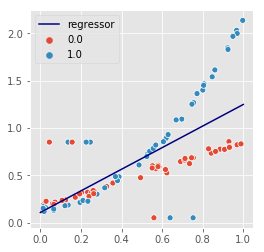

In [3]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)

0   : loss=29.573565
100 : loss=5.766164
200 : loss=5.340643
300 : loss=5.290813
400 : loss=5.269884
500 : loss=5.248684
600 : loss=5.227213
700 : loss=5.206123
800 : loss=5.185940
900 : loss=5.167060
1000: loss=5.149769
1100: loss=5.134245
1200: loss=5.120574
1300: loss=5.108759
1400: loss=5.098737
1500: loss=5.090396
1600: loss=5.083584
1700: loss=5.078129
1800: loss=5.073846
1900: loss=5.070551


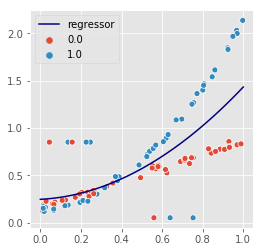

In [4]:
# Fit a linear regression with 2D base expansion using mean squared error.
regression = Poly2RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)

## Linear regression with Adaptive Roust loss

0   : loss=1.299143  alpha=1.004995  scale=0.993690
100 : loss=0.561606  alpha=1.448504  scale=0.478230
200 : loss=0.296927  alpha=1.625770  scale=0.274427
300 : loss=0.291213  alpha=1.559579  scale=0.255816
400 : loss=0.284062  alpha=1.431609  scale=0.241690
500 : loss=0.271398  alpha=1.225408  scale=0.220326
600 : loss=0.245860  alpha=0.905220  scale=0.187537
700 : loss=0.186898  alpha=0.497950  scale=0.138145
800 : loss=0.083783  alpha=0.199858  scale=0.084423
900 : loss=-0.002533  alpha=0.078286  scale=0.052225
1000: loss=-0.035590  alpha=0.038578  scale=0.040360
1100: loss=-0.046182  alpha=0.023907  scale=0.036625
1200: loss=-0.050726  alpha=0.017040  scale=0.035239
1300: loss=-0.053210  alpha=0.013161  scale=0.034574
1400: loss=-0.054768  alpha=0.010684  scale=0.034188
1500: loss=-0.055830  alpha=0.008967  scale=0.033938
1600: loss=-0.056598  alpha=0.007710  scale=0.033753
1700: loss=-0.057197  alpha=0.006751  scale=0.033620
1800: loss=-0.057114  alpha=0.005996  scale=0.033518
19

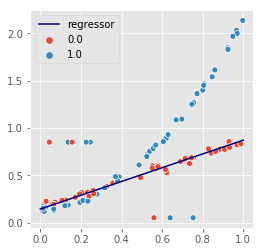

In [5]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)

0   : loss=1.866484  alpha=1.004995  scale=1.006333
100 : loss=0.452028  alpha=1.495429  scale=0.402436
200 : loss=0.263870  alpha=1.622444  scale=0.253168
300 : loss=0.262535  alpha=1.571718  scale=0.248356
400 : loss=0.260887  alpha=1.504078  scale=0.241113
500 : loss=0.258832  alpha=1.415212  scale=0.232054
600 : loss=0.256209  alpha=1.301290  scale=0.220952
700 : loss=0.252685  alpha=1.158169  scale=0.207465
800 : loss=0.247143  alpha=0.976310  scale=0.190496
900 : loss=0.232046  alpha=0.710711  scale=0.164408
1000: loss=0.119381  alpha=0.266798  scale=0.099020
1100: loss=-0.036764  alpha=0.060091  scale=0.044687
1200: loss=-0.068067  alpha=0.024760  scale=0.034454
1300: loss=-0.075596  alpha=0.015095  scale=0.032179
1400: loss=-0.078759  alpha=0.010842  scale=0.031420
1500: loss=-0.080501  alpha=0.008468  scale=0.031035
1600: loss=-0.081603  alpha=0.006952  scale=0.030801
1700: loss=-0.082332  alpha=0.005901  scale=0.030644
1800: loss=-0.082922  alpha=0.005131  scale=0.030531
1900

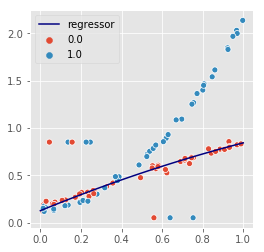

In [6]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)

## Linear regression with Adaptive Roust loss (Model knows group assignment)

0   : loss=1.319446  alpha=1.004995  scale=0.993690
100 : loss=0.500757  alpha=1.453700  scale=0.470137
200 : loss=0.143611  alpha=1.655190  scale=0.248026
300 : loss=0.128071  alpha=1.627128  scale=0.223720
400 : loss=0.125099  alpha=1.564141  scale=0.217166
500 : loss=0.122675  alpha=1.486855  scale=0.210045
600 : loss=0.120115  alpha=1.394925  scale=0.202060
700 : loss=0.117618  alpha=1.292539  scale=0.193572
800 : loss=0.115390  alpha=1.186790  scale=0.185100
900 : loss=0.113465  alpha=1.083063  scale=0.176965
1000: loss=0.111621  alpha=0.979758  scale=0.168930
1100: loss=0.109159  alpha=0.863282  scale=0.159780
1200: loss=0.102454  alpha=0.689533  scale=0.145254
1300: loss=0.063261  alpha=0.366493  scale=0.109763
1400: loss=-0.008611  alpha=0.123830  scale=0.067322
1500: loss=-0.053717  alpha=0.048120  scale=0.045439
1600: loss=-0.072476  alpha=0.023692  scale=0.036587
1700: loss=-0.078948  alpha=0.014775  scale=0.033768
1800: loss=-0.081704  alpha=0.010629  scale=0.032770
1900: l

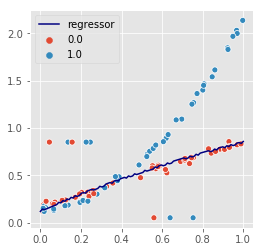

In [7]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel_with_class() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x, U) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U, U)